C:\Users\rojap\AppData\Local\Temp\ipykernel_30752\2505107636.py:47: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


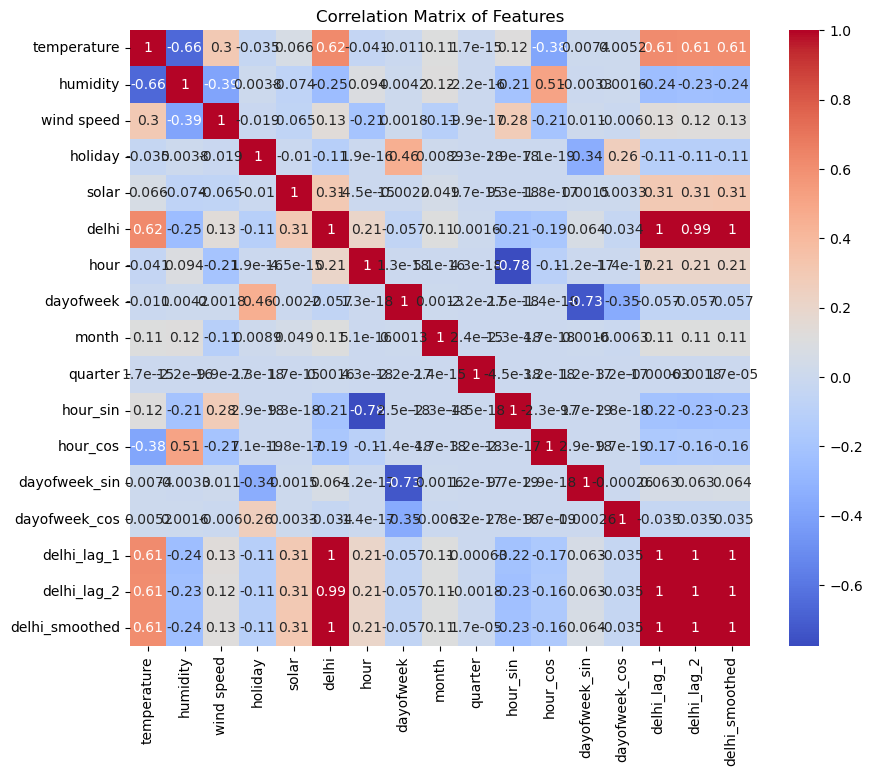

Mean Absolute Error: 16.540656405370132
Root Mean Squared Error: 42.75513920295472
Predictions saved to 'roja_rf_predictions_with_lags.csv'
Model saved in 'random_forest_model_with_lags.pkl'


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
import pickle

# Load the dataset
file_path = 'final.csv'
df = pd.read_csv(file_path)

# Create datetime column and sort the DataFrame
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['time'])
df.sort_values(by='datetime', inplace=True)

# Drop original date and time columns
df.drop(['date', 'time'], axis=1, inplace=True)

# Fill missing values using forward fill
df.fillna(method='ffill', inplace=True)

# Add time-based features
df['hour'] = df['datetime'].dt.hour
df['dayofweek'] = df['datetime'].dt.dayofweek
df['month'] = df['datetime'].dt.month
df['quarter'] = df['datetime'].dt.minute // 15  # Divides minutes into quarters

# Add cyclic features to handle the periodicity of time-based features
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# Create lag features for 'delhi'
df['delhi_lag_1'] = df['delhi'].shift(1).fillna(method='bfill')
df['delhi_lag_2'] = df['delhi'].shift(2).fillna(method='bfill')

# Smooth the target variable 'delhi' using a rolling window
df['delhi_smoothed'] = df['delhi'].rolling(window=4).mean().fillna(df['delhi'])

# Plot correlation matrix
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

# Define the features and target
features = ['temperature', 'humidity', 'wind speed', 'solar', 'holiday',
            'hour_sin', 'hour_cos', 'dayofweek_sin', 'dayofweek_cos',
            'delhi_lag_1', 'delhi_lag_2', 'quarter']
X = df[features].values
y = df['delhi_smoothed'].values

# Scale features
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, shuffle=False)

# Build the Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error: {mae}")
print(f"Root Mean Squared Error: {rmse}")

# Save predictions to a CSV file
predictions_df = pd.DataFrame({
    'datetime': df['datetime'].iloc[-len(y_test):].values,
    'predictions': y_pred.flatten()
})
predictions_df.to_csv('roja_rf_predictions_with_lags.csv', index=False)
print("Predictions saved to 'roja_rf_predictions_with_lags.csv'")

# Save the trained model using pickle
with open('random_forest_model_with_lags.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

print("Model saved in 'random_forest_model_with_lags.pkl'")


In [2]:

# Load and preprocess new data for predictions
new_file_path = 'gani.csv'
new_df = pd.read_csv(new_file_path)

# Preprocess the new data as above
new_df['datetime'] = pd.to_datetime(new_df['date'] + ' ' + new_df['time'])
new_df.sort_values(by='datetime', inplace=True)
new_df.drop(['date', 'time'], axis=1, inplace=True)
new_df.fillna(method='ffill', inplace=True)

# Add time-based and cyclic features
new_df['hour'] = new_df['datetime'].dt.hour
new_df['dayofweek'] = new_df['datetime'].dt.dayofweek
new_df['month'] = new_df['datetime'].dt.month
new_df['quarter'] = new_df['datetime'].dt.minute // 15
new_df['hour_sin'] = np.sin(2 * np.pi * new_df['hour'] / 24)
new_df['hour_cos'] = np.cos(2 * np.pi * new_df['hour'] / 24)
new_df['dayofweek_sin'] = np.sin(2 * np.pi * new_df['dayofweek'] / 7)
new_df['dayofweek_cos'] = np.cos(2 * np.pi * new_df['dayofweek'] / 7)

# Add lag features for new data based on existing data
new_df = pd.merge(new_df, df[['datetime', 'delhi']], on='datetime', how='left')
new_df['delhi_lag_1'] = new_df['delhi'].shift(1)
new_df['delhi_lag_2'] = new_df['delhi'].shift(2)
new_df.fillna(method='bfill', inplace=True)  # Backward fill to handle missing lags

# Prepare features for prediction
new_X = new_df[features].values
new_X_scaled = scaler_X.transform(new_X)

# Load the saved model from pickle file
with open('random_forest_model_with_lags.pkl', 'rb') as file:
    loaded_rf_model = pickle.load(file)

# Predict for new data using the loaded model
new_predictions = loaded_rf_model.predict(new_X_scaled)

# Save new predictions to a CSV file
new_predictions_df = pd.DataFrame({
    'datetime': new_df['datetime'],
    'prediction': new_predictions.flatten()
})
new_predictions_df.to_csv('new_rf_predictions_from_pickle.csv', index=False)
print("New predictions saved to 'new_rf_predictions_from_pickle.csv'")


New predictions saved to 'new_rf_predictions_from_pickle.csv'


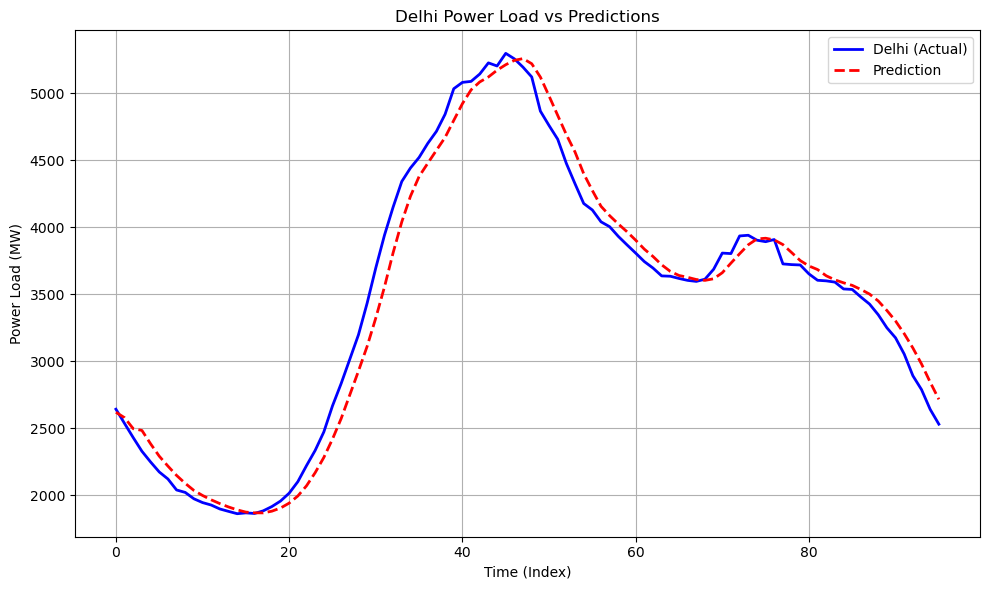

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the 'delhi' column from final.csv and 'prediction' column from new_rf_predictions_with_lags400.csv
delhi_column = pd.read_csv('final.csv')['delhi'][0:96]
prediction_column = pd.read_csv('new_rf_predictions_from_pickle.csv')['prediction'][0:96]

# Ensure both columns have the same length for proper plotting
if len(delhi_column) == len(prediction_column):
    # Create a line chart to plot both columns
    plt.figure(figsize=(10, 6))
    plt.plot(delhi_column, label='Delhi (Actual)', color='blue', linestyle='-', linewidth=2)
    plt.plot(prediction_column, label='Prediction', color='red', linestyle='--', linewidth=2)
    
    plt.title('Delhi Power Load vs Predictions')
    plt.xlabel('Time (Index)')
    plt.ylabel('Power Load (MW)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()
else:
    print("The columns have different lengths and cannot be plotted together.")
